In [232]:
import os
import glob

# Definir diretório base
dir = "observations/"
observation_date = "2011-06-26"
base_path = os.path.join(dir, f'{observation_date}/')

# Usar glob para encontrar todos os arquivos .fit no diretório
file_pattern = os.path.join(base_path, '*.fit')
fits_files = sorted(glob.glob(file_pattern))
print(fits_files[0])
image_name = fits_files[0]

observations/2011-06-26/pg1530-001.fit


In [233]:
from astropy.io import fits

# Carregar a imagem FITS
hdu = fits.open(fits_files[0])
print(hdu)
print(hdu[0].data)

image_data = hdu[0].data

[[1326 1333 1334 ... 1307 1326 1323]
 [1330 1302 1316 ... 1304 1309 1325]
 [1321 1318 1325 ... 1328 1338 1329]
 ...
 [1327 1311 1331 ... 1316 1309 1325]
 [1333 1321 1325 ... 1316 1340 1335]
 [1352 1313 1328 ... 1314 1327 1316]]


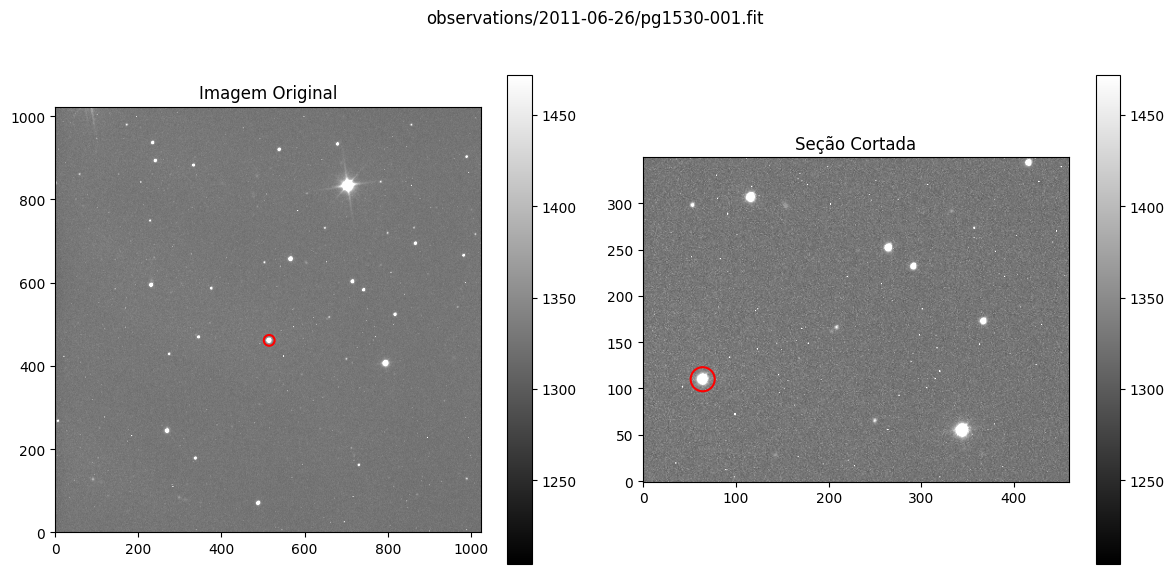

In [360]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture

# Raio da abertura
radius_aperture = 13

# Definindo limites de exibição
vmin = np.percentile(image_data, 80)
vmax = np.percentile(image_data, 80)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 linha e 2 colunas
fig.suptitle(image_name)


############
# Original #
############
x_star = 514.762  # Coordenadas x da estrela
y_star = 461.324  # Coordenadas y da estrela

# Criar aperturas
aperture = CircularAperture((x_star, y_star), r=radius_aperture)

im1 = ax[0].imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
aperture.plot(color='red', lw=1.5,ax=ax[0], label='Aperture')

ax[0].set_title('Imagem Original')
cbar1 = fig.colorbar(im1, ax=ax[0], orientation='vertical')



###########
# Cropped #
###########

image_section = image_data[350:700,450:910]

x_cropped_star = 64  # Coordenadas x da estrela
y_cropped_star = 110  # Coordenadas y da estrela

# Criar apertura
aperture = CircularAperture((x_cropped_star, y_cropped_star), r=radius_aperture)

im2 =ax[1].imshow(image_section, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
aperture.plot(color='red', lw=1.5,ax=ax[1], label='Aperture')

ax[1].set_title('Seção Cortada')
cbar3 = fig.colorbar(im2, ax=ax[1], orientation='vertical')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta o layout para dar espaço ao título
plt.show()

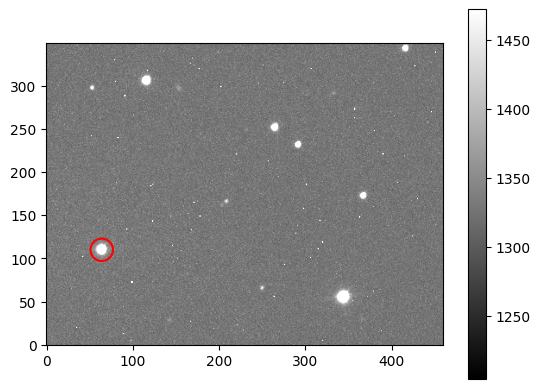

In [354]:
from photutils.aperture import CircularAperture
# Coordenadas da estrela
x_star = 514.762  # Coordenadas x da estrela
y_star = 461.324  # Coordenadas y da estrela

# Definir os raios da abertura e do anel
radius_aperture = 13  # Raio da abertura
radius_in = 15         # Raio interno do anel (igual ao IRAF)
dannulus = 5           # Largura do anel de fundo

# Criar aperturas
aperture = CircularAperture((x_star, y_star), r=radius_aperture)

# Plotar a imagem com limites definidos
plt.imshow(image_section, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
aperture.plot(color='red', lw=1.5, label='Aperture')
plt.colorbar()
plt.show()

IMAGE: observations/2011-06-26/pg1530-001.fit
XINIT: 514.762 YINIT: 461.324
FLUX: nan FERR: nan
MAG: inf MERR: inf
SUM: nan
BKG: nan


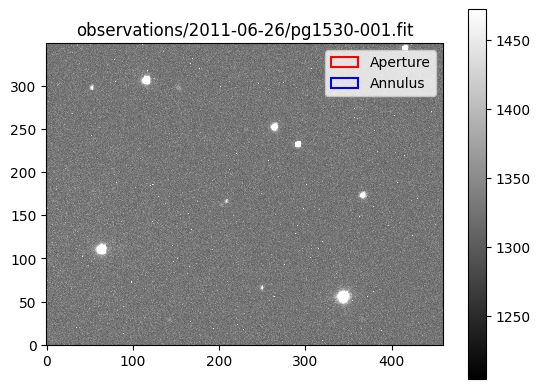

In [295]:

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

# Coordenadas da estrela
x_star = 514.762  # Coordenadas x da estrela
y_star = 461.324  # Coordenadas y da estrela

# Definir os raios da abertura e do anel
radius_aperture = 13  # Raio da abertura
radius_in = 15         # Raio interno do anel (igual ao IRAF)
dannulus = 5           # Largura do anel de fundo

# Criar aperturas
aperture = CircularAperture((x_star, y_star), r=radius_aperture)
annulus = CircularAnnulus((x_star, y_star), r_in=radius_in, r_out=radius_in + dannulus)

# Realizar a fotometria de abertura
photometry = aperture_photometry(image_section, aperture)

# Calcular a soma das contagens no anel
bkg_photometry = aperture_photometry(image_section, annulus)
bkg_mean = bkg_photometry['aperture_sum'][0] / annulus.area
bkg_sum = bkg_mean * annulus.area

# Subtrair o fundo da medida total
flux_total = photometry['aperture_sum'][0] - bkg_sum

# Calcular o erro
error_flux = np.sqrt(photometry['aperture_sum'][0]) + np.sqrt(bkg_sum)

# Cálculo da magnitude
zmag = 25  # Exemplo de zero-point
magnitude = zmag - 2.5 * np.log10(flux_total) if flux_total > 0 else np.inf

if flux_total > 0:
    MERR = (1.0857 * error_flux) / flux_total
else:
    MERR = np.inf  # Erro infinito se o fluxo total for zero

# Exibir os resultados semelhantes ao IRAF
print(f"IMAGE: {image_name}")
print(f"XINIT: {x_star:.3f} YINIT: {y_star:.3f}")
print(f"FLUX: {flux_total:.3f} FERR: {error_flux:.3f}")
print(f"MAG: {magnitude:.3f} MERR: {MERR:.3f}")
print(f"SUM: {photometry['aperture_sum'][0]:.3f}")
print(f"BKG: {bkg_sum:.3f}")

# Definindo limites de exibição
vmin = np.percentile(image_section, 80)  # 5º percentil
vmax = np.percentile(image_section, 80)  # 95º percentil

# Plotar a imagem com limites definidos
plt.imshow(image_section, cmap='gray', origin='lower', vmin=vmin, vmax=vmax, interpolation='nearest')
aperture.plot(color='red', lw=1.5, label='Aperture')
annulus.plot(color='blue', lw=1.5, label='Annulus')
plt.colorbar()
plt.title(image_name)
plt.legend()

# Adicionar informações como labels na imagem
textstr = '\n'.join((
    f"FLUX: {flux_total:.3f}",
    f"FERR: {error_flux:.3f}",
    f"MAG: {magnitude:.3f}",
    f"MERR: {MERR:.3f}",
    f"SUM: {photometry['aperture_sum'][0]:.3f}",
    f"BKG: {bkg_sum:.3f}"
))

# Definir a posição do texto (ajuste conforme necessário)
x_text = 0.05 * image_data.shape[1]  # 5% da largura da imagem
y_text = 0.95 * image_data.shape[0]  # 95% da altura da imagem

# Adicionar o texto à imagem
#plt.text(x_text, y_text, textstr, fontsize=10, color='white', ha='left', va='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='white', facecolor='black', alpha=0.8))


# Salvar plot
#plt.savefig(f"{image_name.replace('fit','')}.jpg")
plt.show()
